# Aug ??st, 2021 (play boot)

**Motivation**: SVINET <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'cosine',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

k = 6
p = 20
figs_dir = [
    mice.cfg.results_dir,
    'SVINET',
    'figs_combined',
    '-'.join([
        f"{svinet_props.get('graph_type', 'real')}",
        f"p{p}",
        f"k{k}",
    ]),
]
figs_dir = pjoin(*figs_dir)
os.makedirs(figs_dir, exist_ok=True)
print(figs_dir)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6

## Align loaded fits using svinet.gam

In [3]:
svinet = SVINET(mice, k, p, 'sub-SLC')
result = align_svinet_group(mice, k=k, p=p, **svinet_props)
list(result)

current expt: 'p20'

['perms', 'gam', 'pi', 'gamma_all', 'svinet_all']

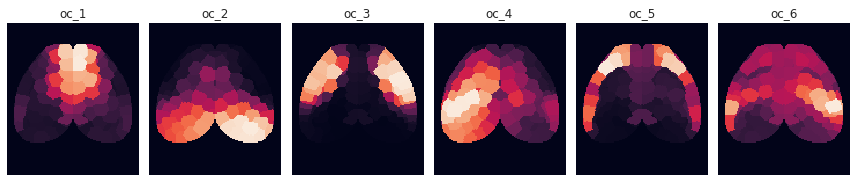

In [4]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))
gam_arr = svinet.pi2arr(result['pi'], cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

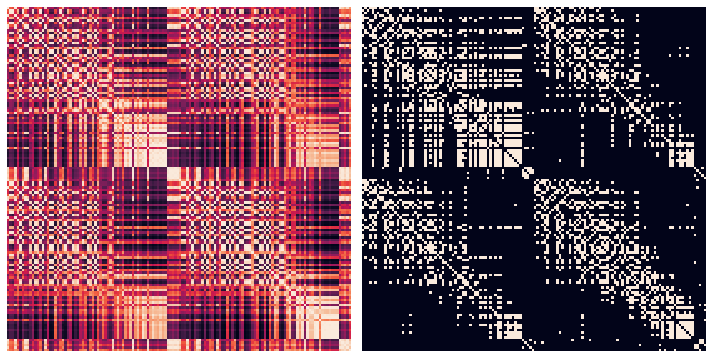

In [5]:
fig, axes = create_figure(1, 2, (10, 7))
d = sp_dist.pdist(result['pi'].T, metric='cosine')
d = sp_dist.squareform(d)
im = axes[0].imshow(dist2sim(d))

axes[1].imshow(svinet.adjacencies[20].astype(bool))
remove_ticks(axes)
plt.show()

In [5]:
fix_idx = np.concatenate([
    np.array(list(v.values())).reshape(1, -1)
    for v in result['perms'].values()
])
ctr = {}
for i in range(k):
    ctr[i] = collections.Counter(fix_idx[:, i]).most_common()
ctr

{
    0: [(0, 20), (4, 4), (3, 3), (5, 2), (1, 1)],
    1: [(1, 25), (0, 5)],
    2: [(2, 30)],
    3: [(3, 15), (5, 8), (1, 3), (4, 2), (0, 2)],
    4: [(4, 22), (5, 6), (1, 1), (3, 1)],
    5: [(5, 14), (3, 11), (0, 3), (4, 2)]
}

In [7]:
### Run below to see if they are aligned goodly

  0%|          | 0/30 [00:00<?, ?it/s]

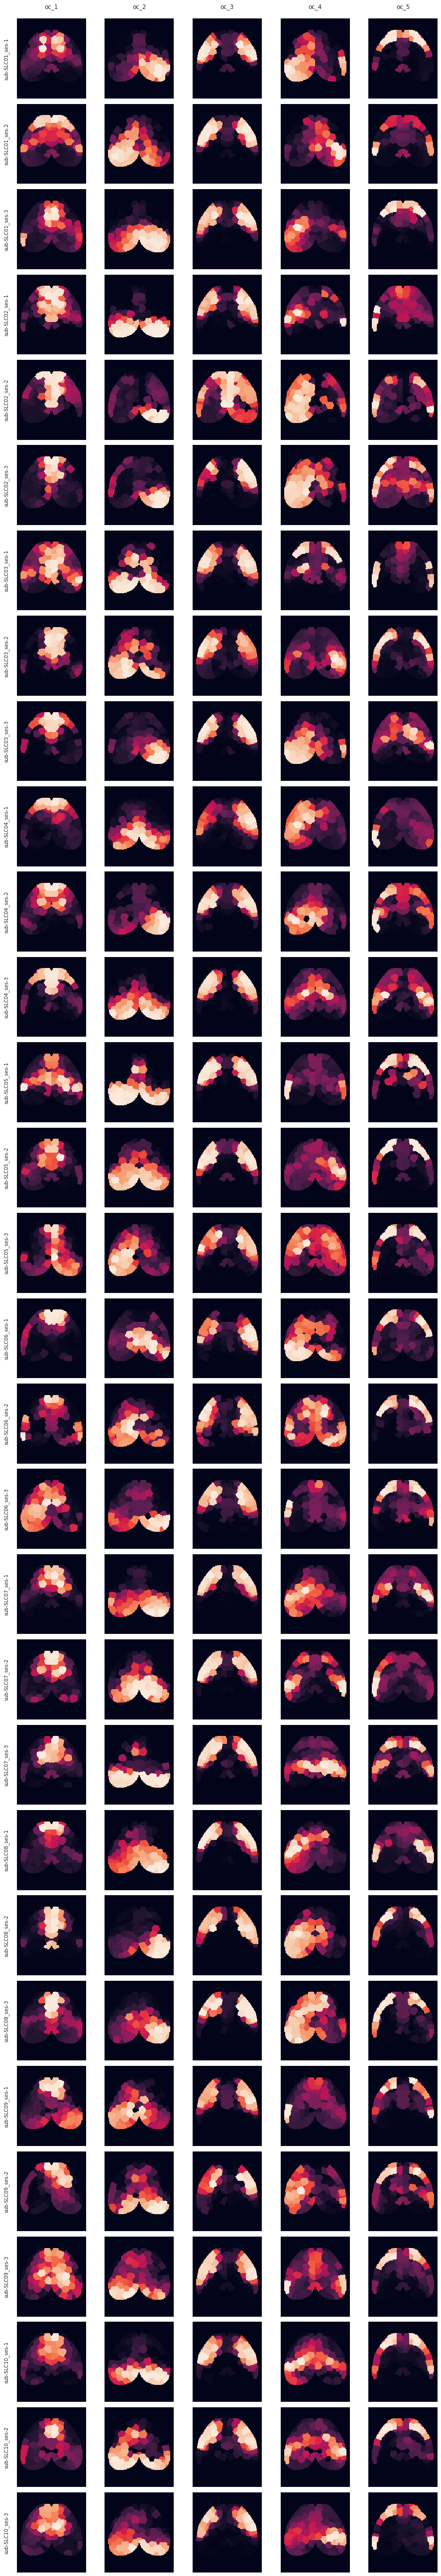

In [8]:
nrows = len(result['gamma_all'])
fig, axes = create_figure(nrows, k, (13, 2.4 * nrows))

for i, (key, gam) in tqdm(enumerate(result['gamma_all'].items()), total=nrows):
    gam_arr = svinet.pi2arr(gam, cortex_only=True)
    for j, idx in enumerate(range(1, k + 1)):
        im = axes[i, j].imshow(gam_arr[idx], cmap='rocket', vmin=0)
        # plt.colorbar(im, ax=axes[i, j], shrink=0.5)
        if i == 0:
            axes[i, j].set_title(f"oc_{idx}\n")
        if j == 0:
            axes[i, j].set_ylabel(f"{key}\n")
remove_ticks(axes)
plt.show()

## BOOTSTRAP (light)

In [6]:
import re

def _extract_seed(x):
    x = next(e for e in str(x).split('-') if 'seed' in e)
    x = re.sub(r"\D", "", x)
    return int(x)

In [7]:
# find shared seeds

seeds_shared = set(range(1, 1000 + 1))
for sub in mice.cfg.sub_ids:
    data_ses = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        df = result['svinet_all'][key].pi_cut_df
        s = list(map(_extract_seed, df['run']))
        seeds_shared.intersection_update(set(s))
len(seeds_shared)

835

In [8]:
intervals = None

data_all = []
for sub in tqdm(mice.cfg.sub_ids):
    data_ses = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        df = result['svinet_all'][key].pi_cut_df.copy()
        if intervals is None:
            intervals = df.interval.unique()
        df = pd.concat([pd.DataFrame(columns=['seed']), df], axis=1)
        df['seed'] = list(map(_extract_seed, df['run']))
        df = df.loc[df['seed'].isin(seeds_shared)]
        df = df.set_index([df['seed'], df['oc_idx'], df['interval']])
        df = df.drop(columns=['run', 'seed', 'oc_idx', 'interval', 'count'])
        data = df.unstack().values
        data = data.reshape((len(seeds_shared), k, len(intervals)))
        data = data[:, list(result['perms'][key].values()), :]
        data_ses.append(np.expand_dims(data, axis=0))
    data_ses = np.concatenate(data_ses)
    data_all.append(np.expand_dims(data_ses, axis=0))
data_all = np.concatenate(data_all)
data_all.shape

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 3, 835, 6, 10)

In [9]:
n_boot = int(1e4)

booted = bootstrap(
    data=data_all,
    n_boot=n_boot,
)
booted.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 6, 10)

<AxesSubplot:xlabel='mean', ylabel='Density'>

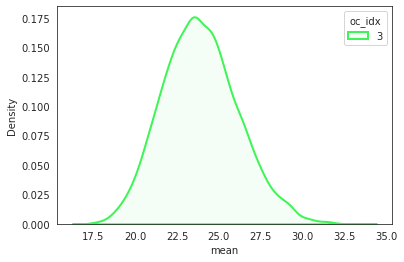

In [10]:
i = 2
j = 9

_df = pd.DataFrame({
    'interval': [intervals[j]] * len(booted),
    'oc_idx': [i + 1] * len(booted),
    'mean': booted[:, i, j],
})
sns.kdeplot(
    data=_df,
    x='mean',
    hue='oc_idx',
    fill=True,
    alpha=0.05,
    lw=2,
    palette=svinet.colors,
)

<AxesSubplot:xlabel='mean', ylabel='Count'>

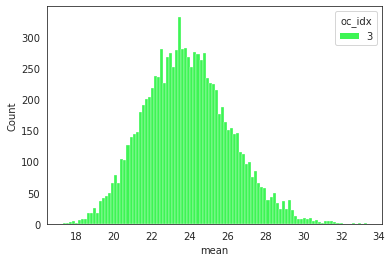

In [11]:
i = 2
j = 9

_df = pd.DataFrame({
    'interval': [intervals[j]] * len(booted),
    'oc_idx': [i + 1] * len(booted),
    'mean': booted[:, i, j],
})
sns.histplot(
    data=_df,
    x='mean',
    hue='oc_idx',
    alpha=1,
    bins=100,
    #kde=True,
    palette=svinet.colors,
)

In [60]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.0: [0.0, 100.0],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted),
                'oc_idx': [i + 1] * len(booted),
                'mean': booted[:, i, j].astype(float),
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            cumulative=False,
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'kde',
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/kde_bins-10_boot-1e+04.pdf

done.

In [12]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.0: [0.0, 100.0],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted),
                'oc_idx': [i + 1] * len(booted),
                'mean': booted[:, i, j],
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.histplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            alpha=0.5,
            bins=100,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'hist',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/hist_bins-10_boot-1e+04.pdf

done.

## Scipy bootstrap

In [12]:
my_statistic = get_statistic_fn(
    axis_sub=-1,
    axis_ses=0,
    axis_seed=1,
    keepdims=False,
)
n_resamples = 2000
batch = 2000
dlist = []
for method in tqdm(['percentile', 'basic', 'bca']):
    for ci in tqdm([95, 99, 99.9, 99.99], leave=False):
        boot = sp_stats.bootstrap(
            data=(data_all,),
            statistic=my_statistic,
            confidence_level=ci/100,
            n_resamples=n_resamples,
            batch=batch,
            method=method,
            random_state=mice.cfg.random_state,
        )
        for i in range(k):
            for j, intvl in enumerate(intervals):
                _res = {
                    'se': boot.standard_error[i, j],
                    'low': boot.confidence_interval.low[i, j],
                    'high': boot.confidence_interval.high[i, j],
                }
                dlist.append({
                    'ci': [ci] * len(_res),
                    'method': [method] * len(_res),
                    'oc_idx': [i + 1] * len(_res),
                    'interval': [intvl] * len(_res),
                    'label': _res.keys(),
                    'value': _res.values(),
                })
df_boot = pd.DataFrame(merge_dicts(dlist))
_ = save_obj(
    obj=df_boot,
    file_name=f"boot_{now()}",
    save_dir=tmp_dir,
    mode='df',
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[PROGRESS] 'boot_(2021_08_18).df' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [13]:
dlist = []
for ci in df_boot.ci.unique():
    q = np.round((100 - ci) / 2, 3)
    vals = np.percentile(
        a=booted,
        q=[q, 100 - q],
        axis=0,
    )
    for i in range(k):
        for j, intvl in enumerate(intervals):
            _res = {
                'low': vals[0, i, j],
                'high': vals[1, i, j],
            }
            dlist.append({
                'ci': [ci] * len(_res),
                'method': ['me'] * len(_res),
                'oc_idx': [i + 1] * len(_res),
                'interval': [intvl] * len(_res),
                'label': _res.keys(),
                'value': _res.values(),
            })
df_boot2 = pd.DataFrame(merge_dicts(dlist))

In [14]:
df = pd.concat([df_boot, df_boot2], axis=0)

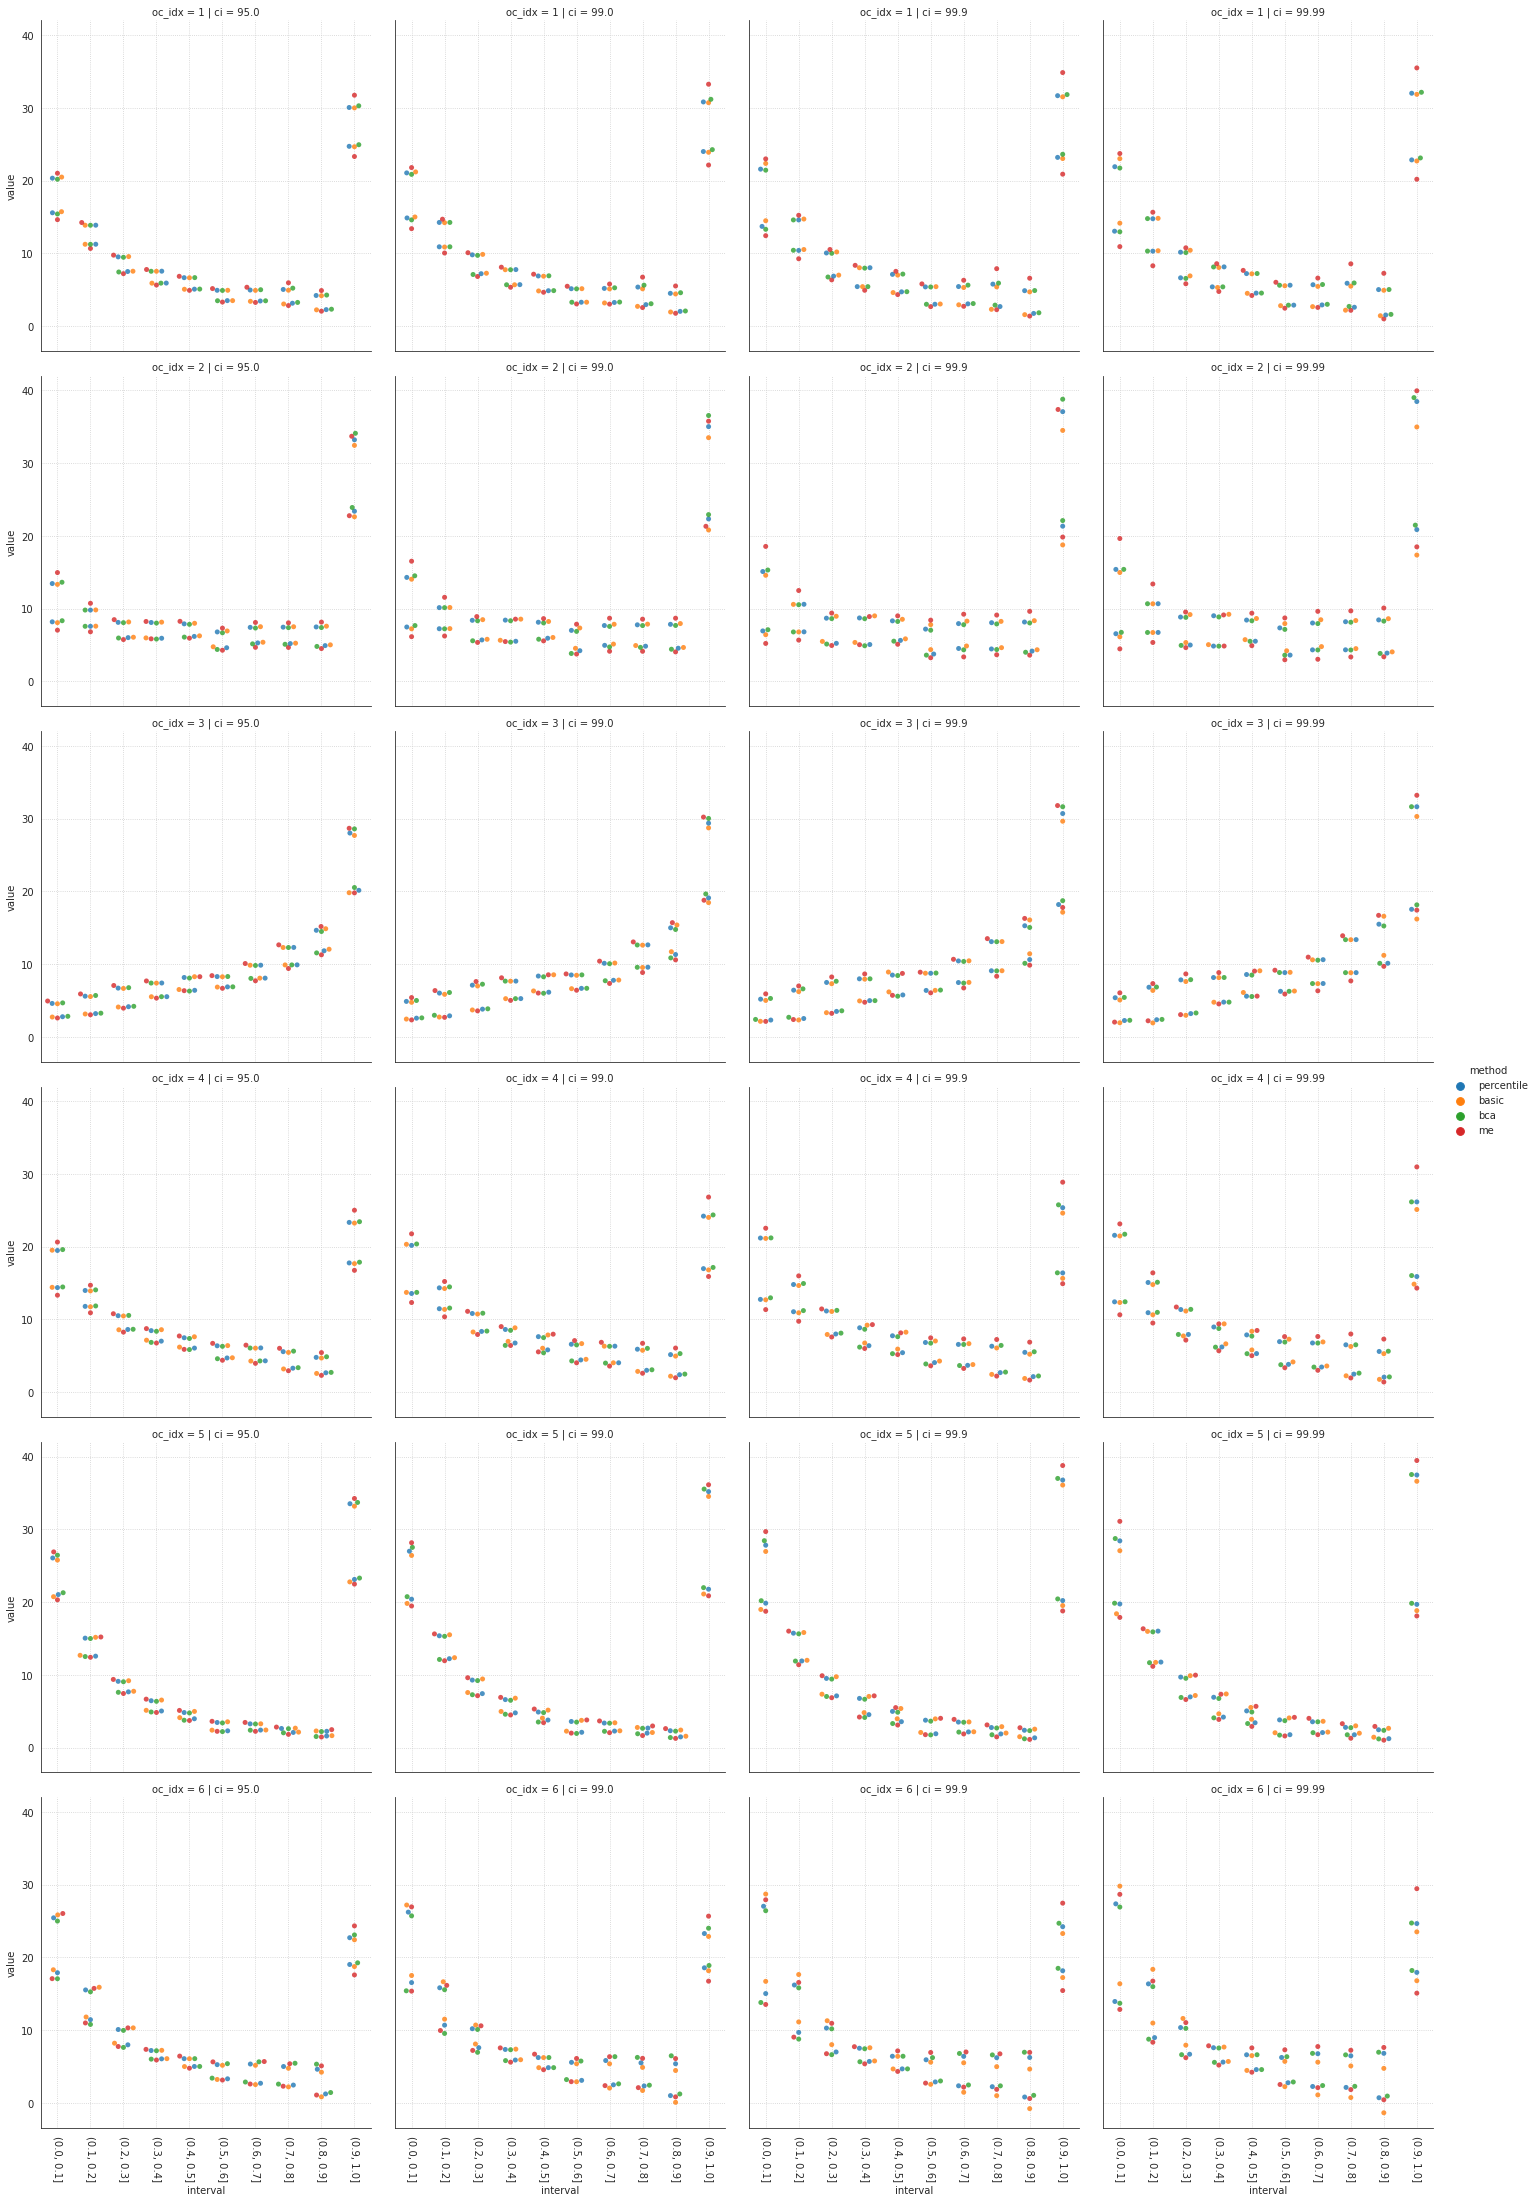

In [25]:
fg = sns.catplot(
    data=df.loc[df.label != 'se'],
    x='interval',
    y='value',
    hue='method',
    col='ci',
    row='oc_idx',
    alpha=0.8,
    kind='swarm',
)
for ax in fg.axes.ravel():
    ax.tick_params(axis='x', rotation=-90)
    ax.grid(ls=':')
fg.fig.savefig(pjoin('/home/hadi/Dropbox/Proj-Overlap-Figs', 'bootstrap_methods.pdf'), bbox_inches='tight')

In [54]:
_df = df.loc[(df.label == 'se') & (df.method == 'bca')]
_df = _df.groupby(['oc_idx', 'interval']).mean().unstack()['value']

In [55]:
_df

interval,"(0.0, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]","(0.5, 0.6]","(0.6, 0.7]","(0.7, 0.8]","(0.8, 0.9]","(0.9, 1.0]"
oc_idx,,,,,,,,,,
1,1.208307,0.671287,0.518766,0.416190,0.403489,0.363801,0.388969,0.486589,0.495185,1.367213
2,1.350682,0.556513,0.534803,0.561045,0.440579,0.560754,0.547600,0.583046,0.651068,2.516280
3,0.468650,0.617682,0.655041,0.478742,0.447659,0.359276,0.453697,0.606813,0.725250,2.028934
4,1.308792,0.555694,0.483892,0.371734,0.366801,0.425139,0.455866,0.585759,0.549442,1.423484
5,1.295151,0.629387,0.369758,0.362689,0.221194,0.297632,0.216394,0.139504,0.166237,2.661008
6,1.952310,1.065832,0.547909,0.291482,0.272515,0.496997,0.682725,0.670219,0.893622,0.933132


In [56]:
se = _df.values

In [57]:
se

array([[1.20830746, 0.67128705, 0.51876554, 0.41619016, 0.40348883,
        0.36380101, 0.38896924, 0.48658894, 0.49518467, 1.36721311],
       [1.35068164, 0.55651314, 0.53480253, 0.56104488, 0.44057932,
        0.56075383, 0.54759975, 0.58304631, 0.65106813, 2.51628007],
       [0.46864999, 0.6176819 , 0.65504137, 0.47874197, 0.44765885,
        0.35927641, 0.4536974 , 0.60681251, 0.72524958, 2.02893449],
       [1.30879229, 0.55569405, 0.48389192, 0.37173436, 0.366801  ,
        0.42513874, 0.45586574, 0.58575931, 0.54944231, 1.42348433],
       [1.29515117, 0.62938692, 0.36975833, 0.36268872, 0.22119413,
        0.297632  , 0.21639429, 0.13950414, 0.16623734, 2.66100827],
       [1.95231033, 1.0658324 , 0.54790884, 0.29148179, 0.27251478,
        0.49699735, 0.68272466, 0.67021931, 0.89362178, 0.93313234]])

In [128]:
real_data = get_statistic_fn(keepdims=False)(data_all)
real_data

array([[18.02456658, 12.55501864,  8.5257301 ,  6.72156372,  5.8573219 ,
         4.20902403,  4.178433  ,  4.03572934,  3.21874432, 27.34611282],
       [10.76692299,  8.70456157,  7.09834279,  7.04359656,  7.09096158,
         5.7853998 ,  6.41106547,  6.35989643,  6.26088534, 27.92108849],
       [ 3.65320108,  4.36218355,  5.3944731 ,  6.45097062,  7.32716572,
         7.55767205,  8.95279274, 11.08288271, 13.33864867, 23.90433695],
       [16.94340941, 12.85731805,  9.54389468,  7.80211952,  6.83759987,
         5.55249133,  5.18045659,  4.38093748,  3.67982281, 20.50121088],
       [23.39497771, 13.85537731,  8.41766982,  5.77542953,  4.46148321,
         2.91748481,  2.83353505,  2.37085648,  1.93347961, 28.13869619],
       [21.86775773, 13.66765584,  9.14813477,  6.64172837,  5.53963002,
         4.24067652,  3.93186071,  3.60569754,  2.73035063, 20.72275659]])

In [154]:
dlist = []
ci_all = [95, 99.99, 99.9999, 99.999999, 99.99999999, 100 * (1 - 0.05 / (6 * 10))]
for ci in sorted(ci_all):
    p = np.round(1 - ci / 100, 13)
    t = abs(sp_stats.t.ppf(1 - p, 9))
    low = real_data - se * t
    high = real_data + se * t
    for i in range(k):
        for j, intvl in enumerate(intervals):
            _res = {
                'low': low[i, j],
                'real': real_data[i, j],
                'high': high[i, j],
            }
            dlist.append({
                'p': [p] * len(_res),
                't': [t] * len(_res),
                'ci': [ci] * len(_res),
                'oc_idx': [i + 1] * len(_res),
                'interval': [intvl] * len(_res),
                'label': _res.keys(),
                'value': _res.values(),
            })
df_t = pd.DataFrame(merge_dicts(dlist))

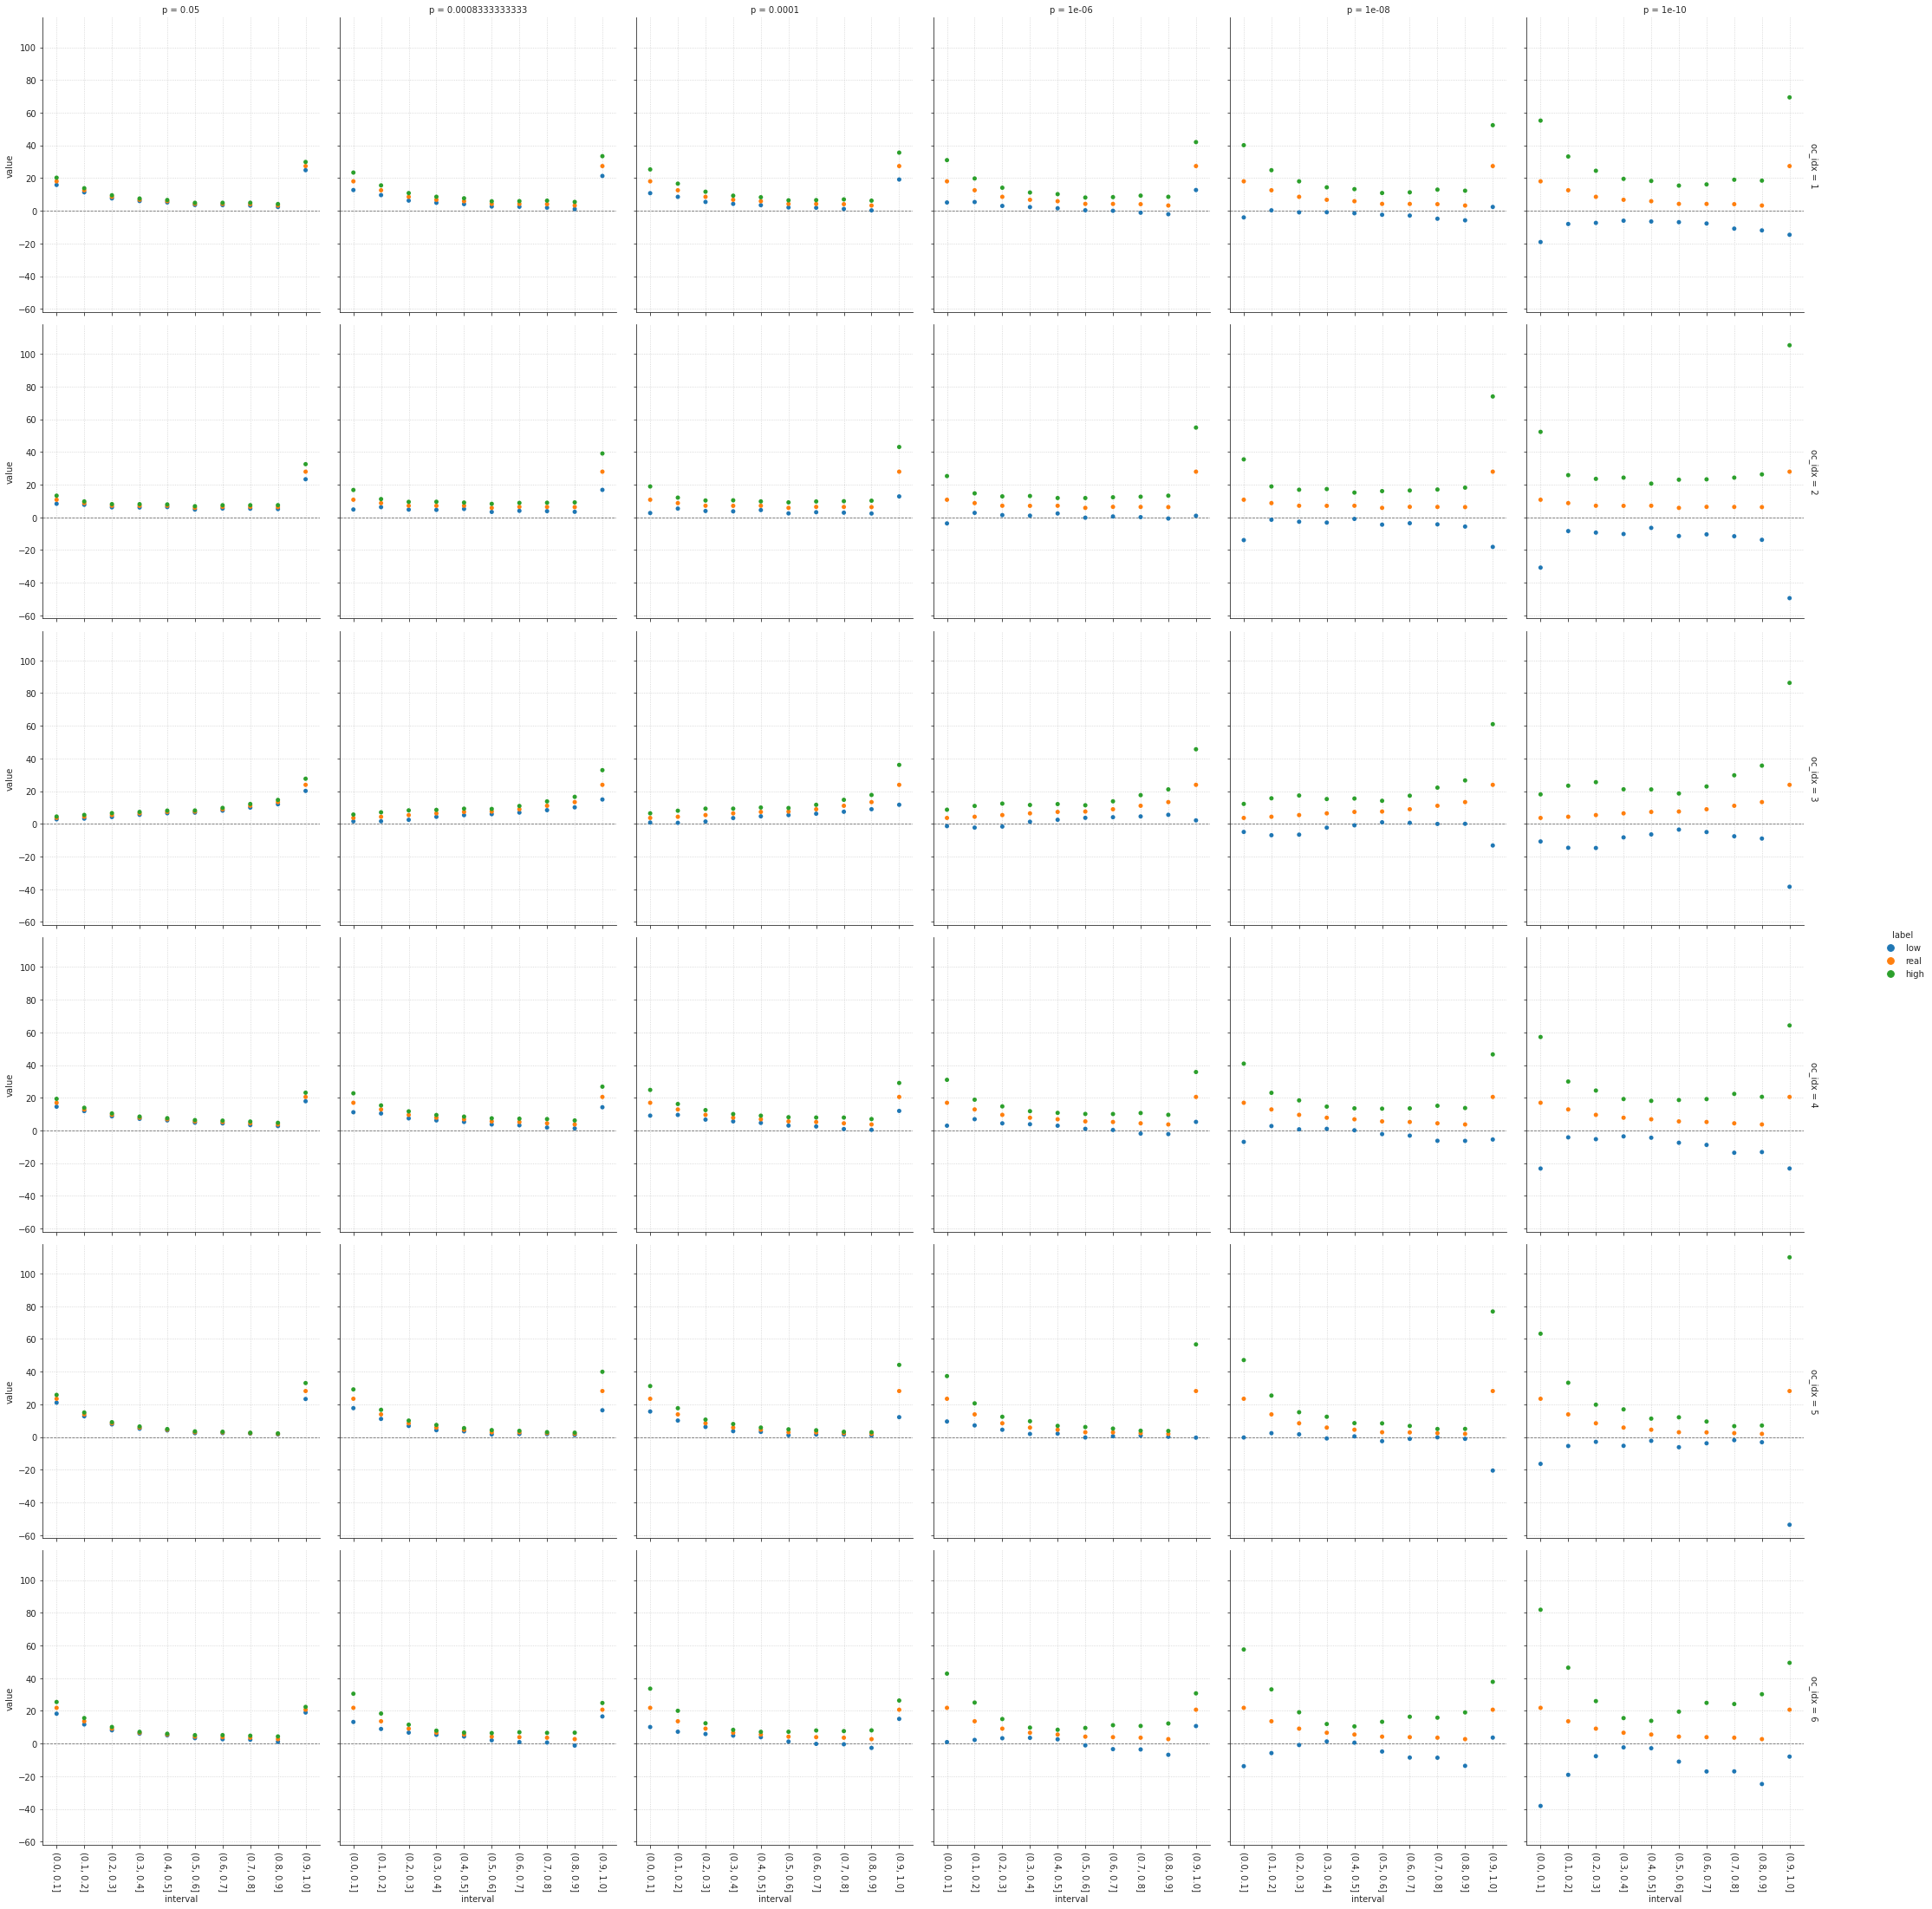

In [164]:
fg = sns.catplot(
    data=df_t,
    x='interval',
    y='value',
    hue='label',
    row='oc_idx',
    col='p',
    col_order=sorted(df_t.p.unique(), reverse=True),
    jitter=False,
    margin_titles=True,
)
for ax in fg.axes.ravel():
    ax.axhline(0, color='dimgrey', lw=0.8, ls='--')
    ax.tick_params(axis='x', rotation=-90)
    ax.grid(ls=':')
fg.fig.savefig(pjoin('/home/hadi/Dropbox/Proj-Overlap-Figs', 'se-bca_with-t.pdf'), bbox_inches='tight')

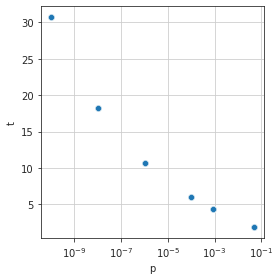

In [162]:
fig, ax = create_figure(1, 1, (4, 4), 'ticks')
sns.scatterplot(data=df_t, x='p', y='t', ax=ax)
ax.set_xscale('log')
ax.grid()

In [165]:
booted.shape

(10000, 6, 10)

<AxesSubplot:ylabel='Count'>

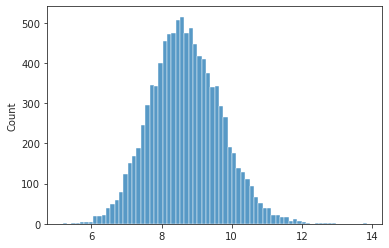

In [167]:
sns.histplot(booted[:, 1, 1])

In [169]:
booted.dtype

dtype('float128')

In [13]:
skew, pval = sp_stats.skewtest(booted.astype(float), axis=0, alternative='two-sided')

In [14]:
skew

array([[ -0.61099684, -12.85556151,  -2.04579877,  -1.56469775,
          4.00566531,   4.07254958,   7.1035936 ,   3.28960125,
         -0.02543452,  13.25426379],
       [ 10.65927019,   5.88515623,   1.78979717,  -2.01227138,
         -2.5540235 ,  -6.71949009,  -4.70380024,   7.80817563,
          9.66187527,  10.44887741],
       [ 13.68337726,   8.99621329,   8.54350874,   6.71988643,
         -6.51433506,  -1.90309693,  -8.96943558,  -6.28428743,
         -7.95623548,  11.10024866],
       [  7.03518732,   0.87355197,  -1.91673123,  -7.39408204,
          1.73987197,   3.69701697,   1.22408968,   8.76443752,
         12.10141355,  14.92109876],
       [ 13.12804612, -10.31995492,  -6.67518922,  -4.93161826,
        -11.59703715,   2.85609684,   6.80329893,  -4.08235208,
          0.68989123,   2.8692865 ],
       [ -3.45059688, -17.66137835, -12.60136102,  -3.14690461,
         -1.541976  ,   3.04783195,   5.14359958,  -6.65408449,
          1.28670343,  10.77075224]])

In [15]:
max_ids = np.unravel_index(np.argmax(np.abs(skew)), skew.shape)
min_ids = np.unravel_index(np.argmin(np.abs(skew)), skew.shape)

Text(0.5, 1.0, 'skewedness: -17.66')

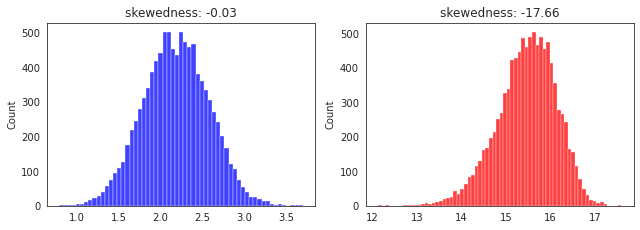

In [16]:
fig, axes = create_figure(1, 2, (9, 3.3))

sns.histplot(booted[:, min_ids[0], min_ids[1]], color='b', ax=axes[0])
sns.histplot(booted[:, max_ids[0], max_ids[1]], color='r', ax=axes[1])

axes[0].set_title(f"skewedness: {skew[min_ids[0], min_ids[1]]:0.2f}")
axes[1].set_title(f"skewedness: {skew[max_ids[0], max_ids[1]]:0.2f}")

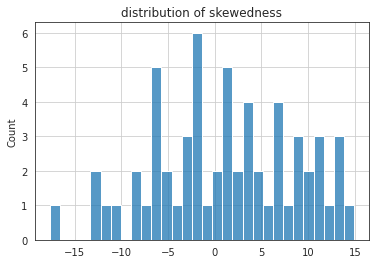

In [17]:
sns.histplot(skew.ravel(), bins=30)
plt.title('distribution of skewedness')
plt.grid()

In [18]:
i, j = max_ids
booted_boxcox, maxlog = sp_stats.boxcox(booted[:, i, j].astype(float))

In [19]:
maxlog

4.521372719064317

<AxesSubplot:ylabel='Count'>

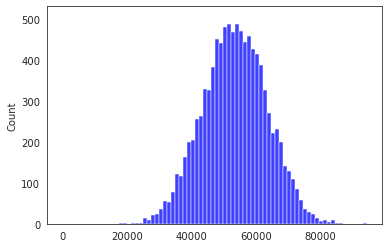

In [20]:
sns.histplot(booted_boxcox, color='b')
sns.histplot(booted[:, i, j].astype(float), color='r')

Text(0.5, 1.0, 'skewedness: -17.66')

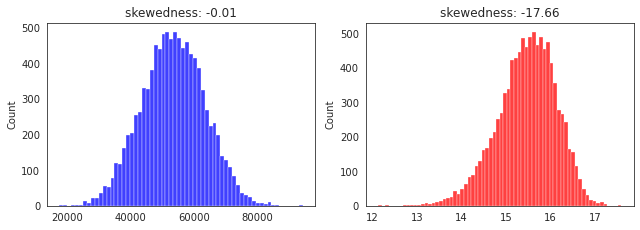

In [21]:
fig, axes = create_figure(1, 2, (9, 3.3))

sns.histplot(booted_boxcox, color='b', ax=axes[0])
sns.histplot(booted[:, max_ids[0], max_ids[1]], color='r', ax=axes[1])

axes[0].set_title(f"skewedness: {sp_stats.skew(booted_boxcox):0.2f}")
axes[1].set_title(f"skewedness: {skew[max_ids[0], max_ids[1]]:0.2f}")

In [225]:
np.std(booted_boxcox)

0.09490923664712261

In [246]:
booted_tr = np.zeros(booted.shape)
lmbda = np.zeros(booted.shape[1:])
for i in range(booted.shape[1]):
    for j in range(booted.shape[2]):
        x, lam = sp_stats.boxcox(booted[:, i, j].astype(float))
        booted_tr[:, i, j] = x
        lmbda[i, j] = lam

In [247]:
skew_tr, _ = sp_stats.skewtest(booted_tr.astype(float), axis=0, alternative='two-sided')

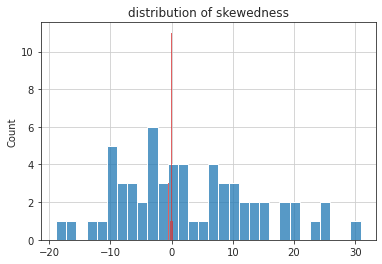

In [248]:
sns.histplot(skew.ravel(), bins=30)
sns.histplot(skew_tr.ravel(), bins=30, color='C3')
plt.title('distribution of skewedness')
plt.grid()

In [249]:
real_data

array([[18.02456658, 12.55501864,  8.5257301 ,  6.72156372,  5.8573219 ,
         4.20902403,  4.178433  ,  4.03572934,  3.21874432, 27.34611282],
       [10.76692299,  8.70456157,  7.09834279,  7.04359656,  7.09096158,
         5.7853998 ,  6.41106547,  6.35989643,  6.26088534, 27.92108849],
       [ 3.65320108,  4.36218355,  5.3944731 ,  6.45097062,  7.32716572,
         7.55767205,  8.95279274, 11.08288271, 13.33864867, 23.90433695],
       [16.94340941, 12.85731805,  9.54389468,  7.80211952,  6.83759987,
         5.55249133,  5.18045659,  4.38093748,  3.67982281, 20.50121088],
       [23.39497771, 13.85537731,  8.41766982,  5.77542953,  4.46148321,
         2.91748481,  2.83353505,  2.37085648,  1.93347961, 28.13869619],
       [21.86775773, 13.66765584,  9.14813477,  6.64172837,  5.53963002,
         4.24067652,  3.93186071,  3.60569754,  2.73035063, 20.72275659]])

In [252]:
real_data_tr = (np.power(real_data, lmbda) - 1) / lmbda
real_data_tr

array([[101.07916844,  85.19771671,  16.02948274,   8.72917182,
          3.55122515,   2.50759932,   1.25708806,   1.0042948 ,
          1.2172879 ,   4.62598399],
       [  4.33769531,   3.45254596,   5.23644798,   8.96055364,
          5.90004805,   4.68388588,   5.95352746,   4.66886001,
          3.42407029,   4.71648741],
       [  1.53285536,   2.24271218,   2.63687731,   2.7304891 ,
         19.77521991,   9.36070181,  46.66764811,  33.86891286,
         68.91484625,   3.01054688],
       [ 16.05495638,  22.18443287,  11.95493185,  43.52176845,
         24.11931348,   4.73855143,   2.90419047,   1.89304823,
          1.49346482,   2.07670502],
       [  2.20467986, 125.8056961 ,  16.98485726,  14.07149185,
         11.61445682,   2.39988956,   1.73939497,   1.56275634,
          0.99322366,   8.75224432],
       [244.64705872, 554.95629388, 179.86721228,  30.71853305,
          1.62268425,   1.27889113,   1.41792364,   1.25103203,
          1.18158004,   2.24402563]])

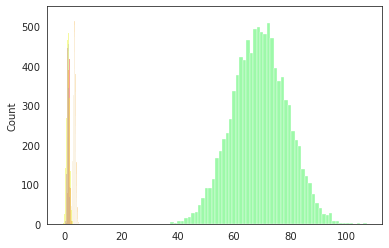

In [235]:
for i in range(k):
    sns.histplot(booted_tr[:, i, 8], alpha=0.5, color=svinet.colors[i+1])

In [238]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted_tr),
                'oc_idx': [i + 1] * len(booted_tr),
                'mean': booted_tr[:, i, j],
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.histplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            alpha=0.5,
            bins=100,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'hist-box-cox',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/3 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/hist-box-cox_bins-10_boot-1e+04.pdf

done.

In [239]:
sp_stats.skewtest(np.random.randn(10000000), axis=0, alternative='two-sided')

SkewtestResult(statistic=0.8494829800985998, pvalue=0.39561259684048355)

<AxesSubplot:ylabel='Count'>

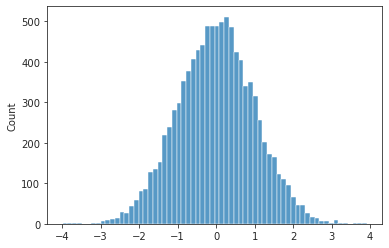

In [178]:
sns.histplot(np.random.randn(10000))

In [116]:
q = 1 - 0.05 / (6 * 10)
# q = 0.0001
t = abs(sp_stats.t.ppf(q, 9))

msg = f"p = {1-q:.3e},\t"
msg += r't^* = '
msg += f"{t}"
print(msg)

p = 8.333e-04,  t^* = 4.421869045738232

In [117]:

y = (x - se * t, x + se * t)

In [118]:
y

(
    array([[12.68158925,  9.58667519,  6.23181683,  4.88122532,  4.07314715,
         2.60034359,  2.45846198,  1.88409676,  1.02910255, 21.3004755 ],
       [ 4.79438566,  6.24373335,  4.73351603,  4.56272958,  5.14277751,
         3.30581978,  3.98965109,  3.781742  ,  3.38194733, 16.79442752],
       [ 1.58089219,  1.63087509,  2.49796596,  4.3340363 ,  5.34767691,
         5.9689988 ,  6.94660226,  8.39963724, 10.13168999, 14.93265432],
       [11.15610129, 10.40011175,  7.40418798,  6.15835886,  5.21565389,
         3.6725835 ,  3.16467797,  1.79078651,  1.25026086, 14.20674959],
       [17.66798882, 11.07231076,  6.78264691,  4.17166752,  3.48339172,
         1.60139509,  1.87666784,  1.75398742,  1.19839986, 16.3720661 ],
       [13.23489713,  8.95468453,  6.72535362,  5.35283407,  4.33460537,
         2.04301932,  0.91294168,  0.6420755 , -1.22112785, 16.5965676 ]]),
    array([[23.36754392, 15.52336209, 10.81964336,  8.56190213,  7.64149664,
         5.81770448,  5.89840403,  6.18736193,  5.40838609, 33.39175014],
       [16.73946031, 11.16538979,  9.46316955,  9.52446355,  9.03914565,
         8.26497982,  8.83247985,  8.93805086,  9.13982335, 39.04774947],
       [ 5.72550997,  7.09349202,  8.29098025,  8.56790494,  9.30665452,
         9.1463453 , 10.95898322, 13.76612818, 16.54560736, 32.87601958],
       [22.73071753, 15.31452436, 11.68360138,  9.44588018,  8.45954585,
         7.43239916,  7.19623522,  6.97108845,  6.10938477, 26.79567218],
       [29.1219666 , 16.63844386, 10.05269272,  7.37919154,  5.4395747 ,
         4.23357453,  3.79040226,  2.98772553,  2.66855936, 39.90532629],
       [30.50061834, 18.38062715, 11.57091593,  7.93062268,  6.74465467,
         6.43833372,  6.95077975,  6.56931958,  6.68182911, 24.84894558]])
)

In [119]:
x

array([[18.02456658, 12.55501864,  8.5257301 ,  6.72156372,  5.8573219 ,
         4.20902403,  4.178433  ,  4.03572934,  3.21874432, 27.34611282],
       [10.76692299,  8.70456157,  7.09834279,  7.04359656,  7.09096158,
         5.7853998 ,  6.41106547,  6.35989643,  6.26088534, 27.92108849],
       [ 3.65320108,  4.36218355,  5.3944731 ,  6.45097062,  7.32716572,
         7.55767205,  8.95279274, 11.08288271, 13.33864867, 23.90433695],
       [16.94340941, 12.85731805,  9.54389468,  7.80211952,  6.83759987,
         5.55249133,  5.18045659,  4.38093748,  3.67982281, 20.50121088],
       [23.39497771, 13.85537731,  8.41766982,  5.77542953,  4.46148321,
         2.91748481,  2.83353505,  2.37085648,  1.93347961, 28.13869619],
       [21.86775773, 13.66765584,  9.14813477,  6.64172837,  5.53963002,
         4.24067652,  3.93186071,  3.60569754,  2.73035063, 20.72275659]])

In [257]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.0: [0.0, 100.0],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted),
                'oc_idx': [i + 1] * len(booted),
                'mean': booted[:, i, j].astype(float),
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            cumulative=False,
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'kde',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/kde_bins-10_boot-1e+04.pdf

done.

In [256]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted),
                'oc_idx': [i + 1] * len(booted),
                'mean': booted[:, i, j].astype(float),
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            cumulative=True,
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'kde-cdf',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/3 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/kde-cdf_bins-10_boot-1e+04.pdf

done.

## Fitter

In [293]:
def best_fit_distribution(data, distn_names, bins=500):
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    best_dists = {}
    for ii, dist in enumerate([d for d in distn_names if d not in ['levy_stable', 'studentized_range']]):
        print("{:>3} / {:<3}: {}".format(ii + 1, len(distn_names), dist))
        dist_fn = getattr(sp_stats, dist)
        params = dist_fn.fit(data)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        pdf = dist_fn.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0))
        best_dists[dist] = (dist_fn, params, sse)
    best_dists = dict(sorted(best_dists.items(), key=lambda e: e[1][2]))
    return best_dists

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.001, loc=loc, scale=scale)
    end = dist.ppf(0.999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.999, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [294]:
distn_names = [
    'alpha', 'beta',
    'gamma', 'lognorm',
    'weibull_min', 'weibull_max',
    't', 'chi2',
]
best_distibutions = best_fit_distribution(
    data=booted[:, max_ids[0], max_ids[1]].astype(float),
    distn_names=distn_names,
    bins=500,
)

1 / 8  : alpha

2 / 8  : beta

3 / 8  : gamma

4 / 8  : lognorm

5 / 8  : weibull_min

6 / 8  : weibull_max

7 / 8  : t

8 / 8  : chi2

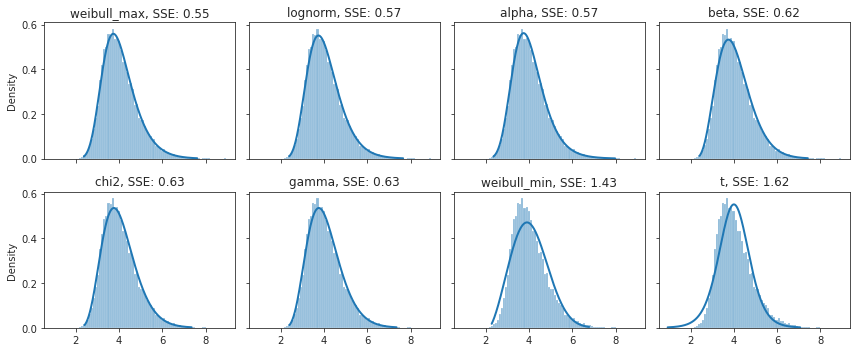

In [297]:
fig, axes = create_figure(2, 4, (12, 5), 'ticks', 'all', 'all')

for ax, (k, v) in zip(axes.ravel(), best_distibutions.items()):
    pdf = make_pdf(v[0], v[1], size=1000)
    ax.plot(list(pdf.index), list(pdf.values), lw=2)
    sns.histplot(booted[:, max_ids[0], max_ids[1]].astype(float), stat='density', alpha=0.5, ax=ax)
    ax.set_title(f"{k}, SSE: {v[2]:.2f}")
plt.show()

In [298]:
best_distibutions2 = best_fit_distribution(
    data=booted[:, min_ids[0], min_ids[1]].astype(float),
    distn_names=distn_names,
    bins=500,
)

1 / 8  : alpha

2 / 8  : beta

3 / 8  : gamma

4 / 8  : lognorm

5 / 8  : weibull_min

6 / 8  : weibull_max

7 / 8  : t

8 / 8  : chi2

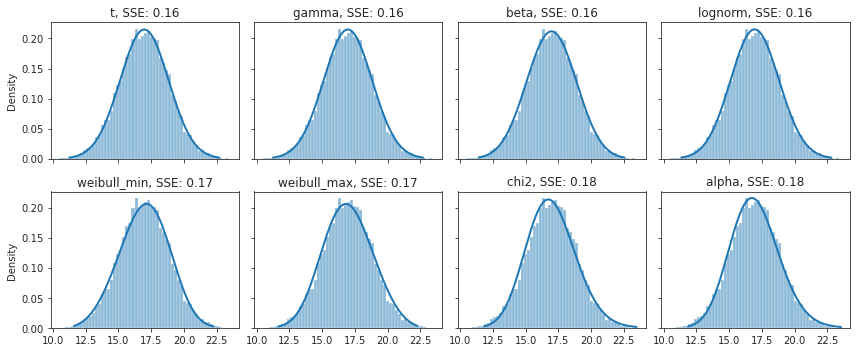

In [299]:
fig, axes = create_figure(2, 4, (12, 5), 'ticks', 'all', 'all')

for ax, (k, v) in zip(axes.ravel(), best_distibutions2.items()):
    pdf = make_pdf(v[0], v[1], size=1000)
    ax.plot(list(pdf.index), list(pdf.values), lw=2)
    sns.histplot(booted[:, min_ids[0], min_ids[1]].astype(float), stat='density', alpha=0.5, ax=ax)
    ax.set_title(f"{k}, SSE: {v[2]:.2f}")
plt.show()

In [302]:
i, j = np.unravel_index(np.argmin(skew), skew.shape)
skew[i, j]

-18.843772460712728

-18.843772460712728

In [303]:
i, j = np.unravel_index(np.argmin(skew), skew.shape)

best_distibutions2 = best_fit_distribution(
    data=booted[:, i, j].astype(float),
    distn_names=distn_names,
    bins=500,
)

1 / 8  : alpha

2 / 8  : beta

3 / 8  : gamma

4 / 8  : lognorm

5 / 8  : weibull_min

6 / 8  : weibull_max

7 / 8  : t

8 / 8  : chi2

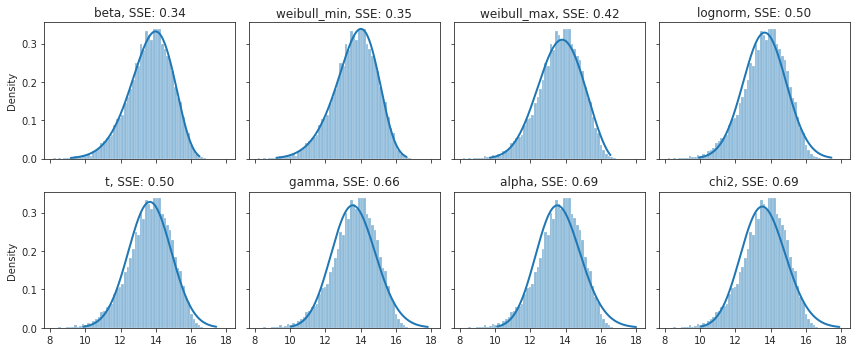

In [304]:
fig, axes = create_figure(2, 4, (12, 5), 'ticks', 'all', 'all')

for ax, (k, v) in zip(axes.ravel(), best_distibutions2.items()):
    pdf = make_pdf(v[0], v[1], size=1000)
    ax.plot(list(pdf.index), list(pdf.values), lw=2)
    sns.histplot(booted[:, i, j].astype(float), stat='density', alpha=0.5, ax=ax)
    ax.set_title(f"{k}, SSE: {v[2]:.2f}")
plt.show()

In [334]:
booted_log = np.log(booted)

<AxesSubplot:ylabel='Density'>

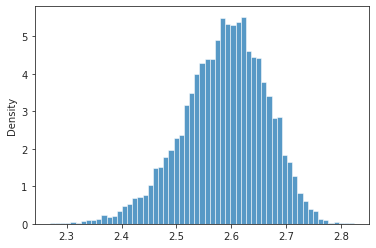

In [335]:
sns.histplot(booted_log[:, 2, 8], stat='density')

<AxesSubplot:ylabel='Density'>

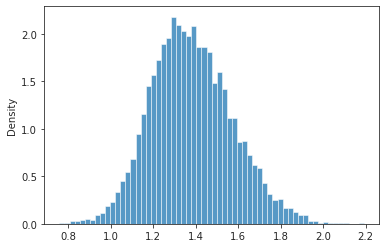

In [336]:
sns.histplot(booted_log[:, max_ids[0], max_ids[1]], stat='density')

<AxesSubplot:ylabel='Density'>

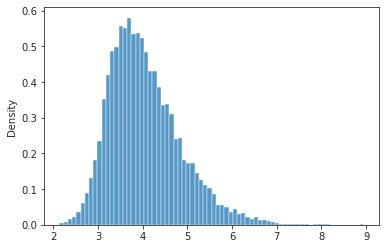

In [337]:
sns.histplot(booted[:, max_ids[0], max_ids[1]], stat='density')

In [339]:
np.log(100)

4.605170185988092

In [342]:
skew_before = sp_stats.skew(booted.astype(float))
skew_after = sp_stats.skew(booted_log.astype(float))

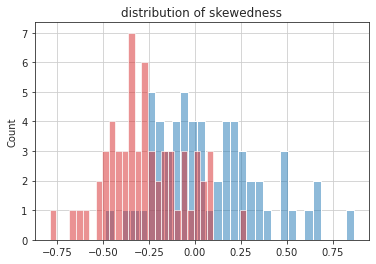

In [343]:
sns.histplot(skew_before.ravel(), bins=30, color='C0', alpha=0.5)
sns.histplot(skew_after.ravel(), bins=30, color='C3', alpha=0.5)
plt.title('distribution of skewedness')
plt.grid()

In [344]:
from sklearn.preprocessing import QuantileTransformer

In [353]:
qt = QuantileTransformer(
    output_distribution='normal',
    n_quantiles=1000,
    random_state=0,
)
booted_tr = qt.fit_transform(booted.reshape(len(booted), -1))
booted_tr = booted_tr.reshape(booted.shape)

<AxesSubplot:ylabel='Count'>

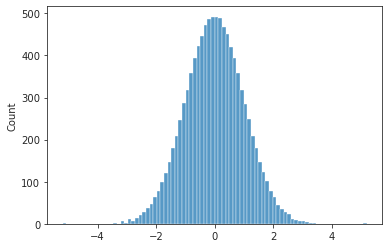

In [354]:
sns.histplot(booted_tr[:, i, j])

<AxesSubplot:ylabel='Count'>

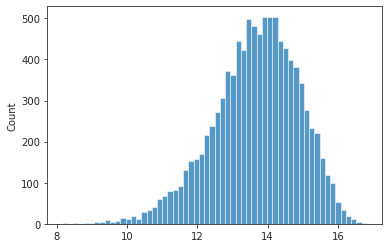

In [355]:
sns.histplot(booted[:, i, j])

In [357]:
real_data_tr = qt.transform(real_data.reshape(1, -1))
real_data_tr = real_data_tr.reshape(real_data.shape)

In [358]:
real_data_tr

array([[-0.0238522 , -0.02979814, -0.0065471 , -0.05142252,  0.00594194,
         0.02241137,  0.07468113,  0.14073878,  0.08635596,  0.03220681],
       [ 0.06501133,  0.05398794, -0.0082951 , -0.04919765, -0.01457294,
        -0.0071343 , -0.0154272 ,  0.03513785,  0.03553733,  0.0451455 ],
       [ 0.05542866,  0.01612663, -0.00214004,  0.02507929, -0.05226562,
         0.01051006, -0.04861821, -0.00594663, -0.02072443,  0.06063239],
       [-0.02143672, -0.00788592, -0.00885013, -0.05847402, -0.06753839,
        -0.00962229,  0.05049708,  0.09394314,  0.09911161,  0.06037793],
       [ 0.05823311, -0.05222858, -0.00242084, -0.04946151, -0.04311003,
        -0.08525942, -0.01533527,  0.18007227, -0.10430058,  0.02652341],
       [-0.05422126, -0.06572383, -0.08183949, -0.08958072,  0.00382831,
         0.10244938,  0.06835919,  0.11996616,  0.11988117,  0.05912278]])

In [359]:
real_data

array([[18.02456658, 12.55501864,  8.5257301 ,  6.72156372,  5.8573219 ,
         4.20902403,  4.178433  ,  4.03572934,  3.21874432, 27.34611282],
       [10.76692299,  8.70456157,  7.09834279,  7.04359656,  7.09096158,
         5.7853998 ,  6.41106547,  6.35989643,  6.26088534, 27.92108849],
       [ 3.65320108,  4.36218355,  5.3944731 ,  6.45097062,  7.32716572,
         7.55767205,  8.95279274, 11.08288271, 13.33864867, 23.90433695],
       [16.94340941, 12.85731805,  9.54389468,  7.80211952,  6.83759987,
         5.55249133,  5.18045659,  4.38093748,  3.67982281, 20.50121088],
       [23.39497771, 13.85537731,  8.41766982,  5.77542953,  4.46148321,
         2.91748481,  2.83353505,  2.37085648,  1.93347961, 28.13869619],
       [21.86775773, 13.66765584,  9.14813477,  6.64172837,  5.53963002,
         4.24067652,  3.93186071,  3.60569754,  2.73035063, 20.72275659]])

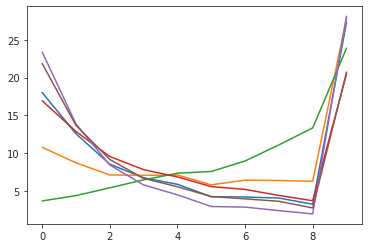

In [361]:
plt.plot(real_data.T);

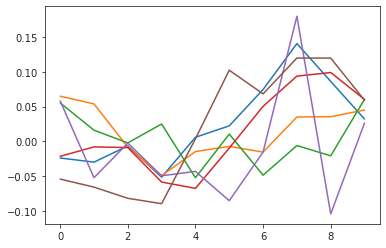

In [362]:
plt.plot(real_data_tr.T);

In [48]:
from fitter import Fitter

distn_names = [
    't',
    'beta',
    'gamma',
    'lognorm',
    'norm',
]
fitted = {}
for i in tqdm(range(k)):
    f = Fitter(
        data=booted[:, i, -2].astype(float),
        distributions=distn_names,
        bins=200,
        timeout=1000,
    )
    f.fit(progress=False)
    fitted[i] = f

  0%|          | 0/6 [00:00<?, ?it/s]

,sumsquare_error,aic,bic,kl_div
beta,0.498434,868.530114,-99029.409362,inf
lognorm,0.521987,825.016039,-98576.894332,inf
gamma,0.522544,821.963150,-98566.229416,inf
t,0.527225,820.575053,-98477.044567,inf
norm,0.527229,818.566805,-98486.189464,inf


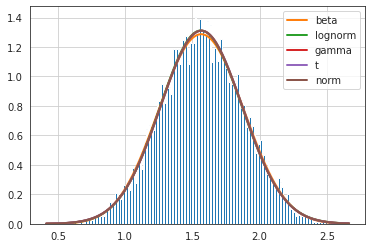

In [59]:
fitted[4].summary()

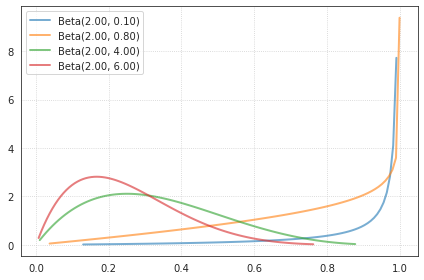

In [388]:
fig, ax = create_figure(1, 1)

a, b = 2., 0.1
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.pdf(x, a, b),
       color='C0', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 0.8
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.pdf(x, a, b),
       color='C1', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 4
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.pdf(x, a, b),
       color='C2', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 6
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.pdf(x, a, b),
       color='C3', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")
ax.grid(ls=':')
ax.legend()
plt.show()

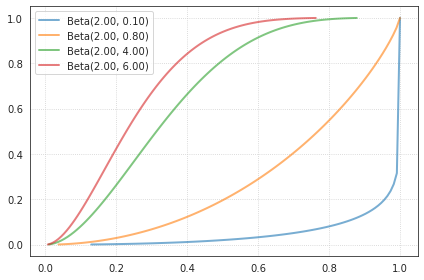

In [389]:
fig, ax = create_figure(1, 1)

a, b = 2., 0.1
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.cdf(x, a, b),
       color='C0', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 0.8
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.cdf(x, a, b),
       color='C1', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 4
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.cdf(x, a, b),
       color='C2', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 6
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.cdf(x, a, b),
       color='C3', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")
ax.grid(ls=':')
ax.legend()
plt.show()

In [390]:
data_all.shape

(10, 3, 835, 6, 10)

In [391]:
x = np.median(data_all, axis=2)
x.shape

(10, 3, 6, 10)

In [395]:
for key, g in result['gamma_all'].items():
    g

In [403]:
pi = g / g.sum(0, keepdims=True)

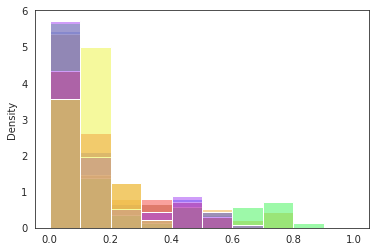

In [407]:
for i in range(k):
    x = result['pi'][i].copy()
    sns.histplot(x[x > 0],
                 color=svinet.colors[i+1],
                 bins=np.linspace(0, 1, 11),
                 alpha=0.5,
                 stat='density',
                )

## New, correct Fig

In [ ]:
real_sample = np.median(data_all, axis=2).mean(1, dtype='float128')

real_sample.shape, booted.shape, data_all.shape

In [ ]:
dlist1, dlist2 = [], []
for i in range(k):
    for j, intvl in enumerate(intervals):
        dlist1.append({
            'condition': ['real'] * len(real_sample),
            'interval': [intvl] * len(real_sample),
            'oc_idx': [i + 1] * len(real_sample),
            'mean': real_sample[:, i, j],
        })
        dlist2.append({
            'condition': ['boot'] * len(booted),
            'interval': [intvl] * len(booted),
            'oc_idx': [i + 1] * len(booted),
            'mean': booted[:, i, j],
        })
df_real = pd.DataFrame(merge_dicts(dlist1))
df_boot = pd.DataFrame(merge_dicts(dlist2))

In [ ]:
df_real.shape, df_boot.shape

In [ ]:
props_boot = {
    'boxprops': {'color': 'none', 'edgecolor': 'k', 'linewidth': 1},
    'medianprops': {'color': 'none', 'linewidth': 0},
    'whiskerprops': {'color': 'k', 'linewidth': 1},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
props_real = {
    'boxprops': {'color': 'none', 'edgecolor': 'none', 'linewidth': 0},
    'medianprops': {'color': 'k', 'linewidth': 1.5},
    'whiskerprops': {'color': 'none', 'linewidth': 0},
    'capprops': {'color': 'none', 'linewidth': 0},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "X",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "8",
}

figs, sups = [], []
cis = [100, 99.9, 99.0, 95.0][::-1]
for ci in tqdm(cis):
    lower = np.round((100 - ci) / 2, 3)
    higher = np.round(100 - (100 - ci) / 2, 3)
    
    nrows = 2
    ncols = int(np.ceil(k / nrows))
    fig, axes = create_figure(
        nrows=nrows,
        ncols=ncols,
        figsize=(13.5, 11),
        style='ticks',
        sharex='all',
        sharey='all',
        reshape=True,
    )

    for ax, oc_idx in zip(axes.ravel(), range(1, k + 1)):
        _df = df_boot.loc[df_boot.oc_idx == oc_idx]
        sns.boxplot(
            data=_df,
            x='interval',
            y='mean',
            palette='turbo',
            whis=[lower, higher],
            showfliers=False,
            ax=ax,
            **props_boot,
        )

        _df = df_real.loc[df_real.oc_idx == oc_idx]
        sns.stripplot(
            x='interval',
            y='mean',
            data=_df,
            palette='turbo',
            size=6,
            alpha=0.5,
            linewidth=0.0,
            ax=ax,
        )
        sns.boxplot(
            data=_df,
            x='interval',
            y='mean',
            palette='turbo',
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=ax,
            **props_real,
        )
        ax.axhline(0, color='dimgrey', lw=0.8, ls='--')
        ax.grid(ls=':')
        ax.tick_params(axis='x', rotation=-90)
        ax.set_title(f"OC{oc_idx}", fontsize=13)
        if (oc_idx - 1) % ncols == 0:
            ax.set_ylabel('mean percentage', fontsize=13)
        else:
            ax.set_ylabel('')
    _ = trim_axs(axes, k)
    msg = f"ci = {ci} % whiskers: [{lower}, {higher}]\n"
    msg += "median, mean and scatter points: 'actual' sample\nwhiskers, caps: 'bootstrapped' samples"
    sup = fig.suptitle(msg, fontsize=17, y=1.05)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'group',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')